In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Ellipse, Rectangle
import os
from tqdm import tqdm
import sep
from astropy.io import fits

In [2]:
base = "/home/max/Development/semester-project/"
xdf = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f160w_v1_"
sci_filename = os.path.join(base, "data", xdf+"sci.fits")
wht_filename = os.path.join(base, "data", xdf+"wht.fits")
sci = fits.open(sci_filename)
wht = fits.open(wht_filename)

In [3]:
image = sci[0].data
image = image.byteswap().newbyteorder()
weight = wht[0].data
weight = weight.byteswap().newbyteorder()
rms = np.zeros_like(weight)
index = (weight > 0)
rms[index] = np.sqrt(1.0/weight[index])

In [4]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

w = WCS(sci[0].header)
position = (3020, 3470)
size = (500, 500)
cutout_image = Cutout2D(image, position, size, wcs=w)
cutout_weight = Cutout2D(weight, position, size, wcs=w)
image_1 = np.ascontiguousarray(cutout_image.data)
weight_1 = np.ascontiguousarray(cutout_weight.data)
rms_1 = np.sqrt(1.0/weight_1)

In [5]:
nthresh = range(32, 1025, 32)
mincont = np.logspace(0, -10, 100)
n = nthresh[15]
m = mincont[60]
%time objects, segmap = sep.extract(image_1, 1.5, err=rms_1, deblend_nthresh=n, deblend_cont=m, segmentation_map=True)
print("Running SEcxtractor with NTHRESH={}, MINCONT={:.0E}".format(n, m))

CPU times: user 271 ms, sys: 24.5 ms, total: 296 ms
Wall time: 294 ms
Running SEcxtractor with NTHRESH=512, MINCONT=9E-07


# Ellipses

In [6]:
def plot_detections(image, objects):
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    props = dict(boxstyle='round', facecolor='wheat')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(image, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
    for o in objects:
        ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='red', facecolor='none')
        ax.add_artist(ellipse)
    ax.text(0.9,0.9, "NTHRESH={}\n MINCONT={:.0E}\n DETECTIONS={}".format(n, m, len(objects)), transform=ax.transAxes, ha="right", bbox=props)
    fig.colorbar(im, cax=cax, orientation='vertical')

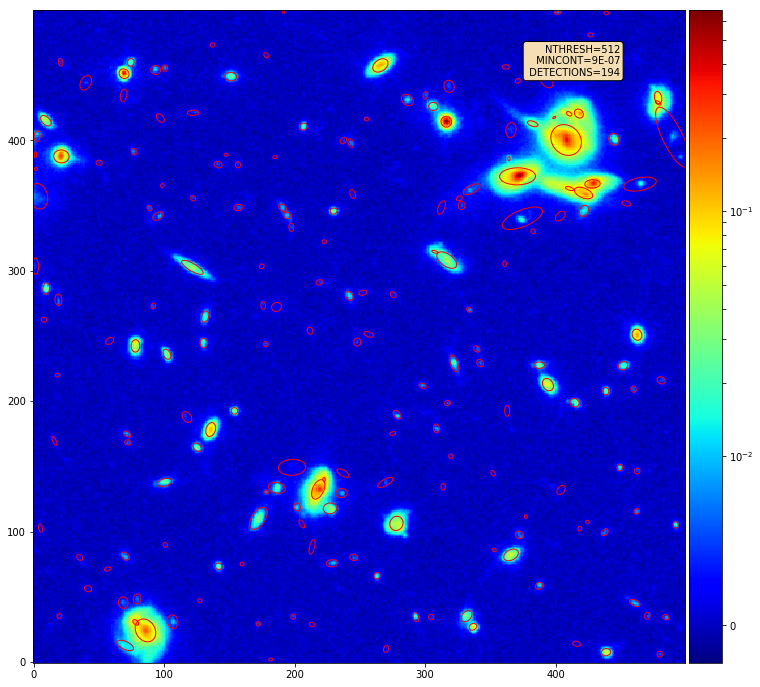

In [7]:
plot_detections(image_1, objects)

## Distribution of ellipse angles

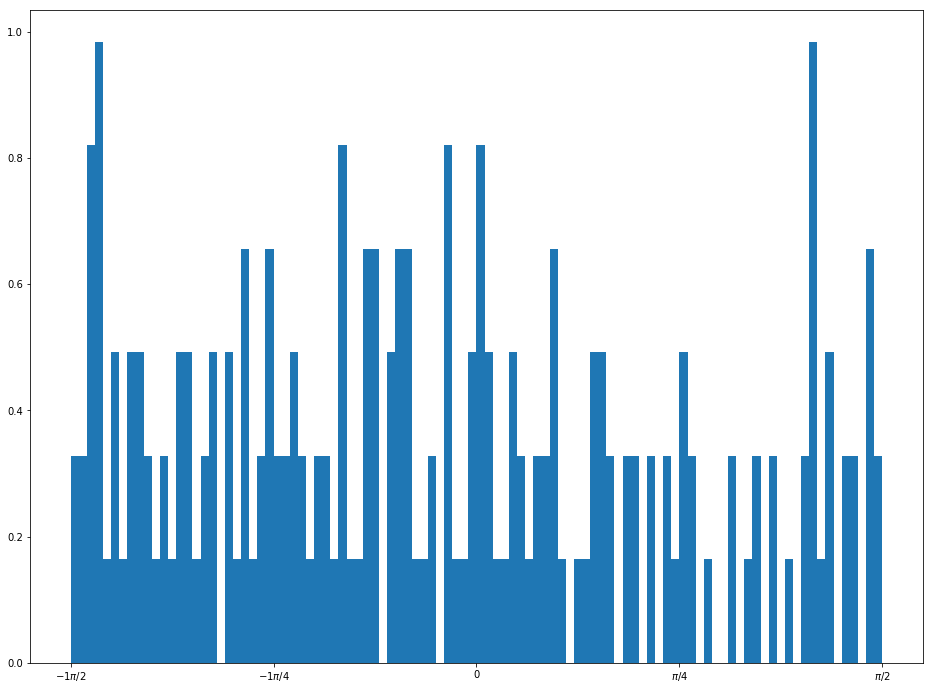

In [8]:
angles = np.zeros(len(objects))
for (i, o) in enumerate(objects):
    angles[i] = o['theta']

def format_func(value, tick_number):
    N = int(np.round(4 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/4$"
    elif N == 2:
        return r"$\pi/2$"
    elif N % 2 > 0:
        return r"${0}\pi/4$".format(N)
    else:
        return r"${0}\pi/2$".format(N // 2)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
hist = ax.hist(angles, bins=100, range=(-np.pi/2.0, np.pi/2.0), density=True)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Detecting asymmetries

In order to detect asymmetric objects, we will look at the separation between the coordinates of the barycentre and of the largest peak in each object. If the separation is larger than a certain threshold we classify the object as asymmetric.

(0, 500)

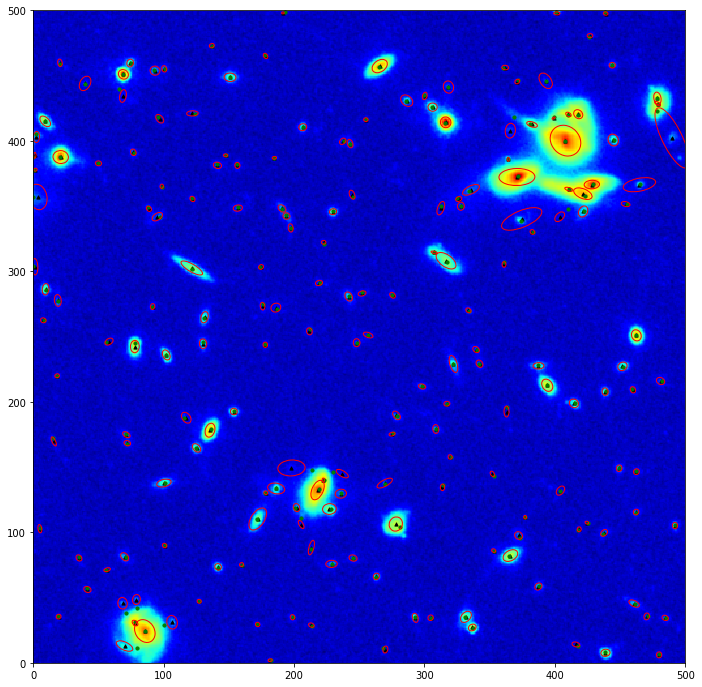

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(image_1, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for (i, o) in enumerate(objects):
    ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='red', facecolor='none')
    ax.add_artist(ellipse)
    ax.scatter(o['x'], o['y'], s=10, c='black', marker='^')
    ax.scatter(o['xpeak'], o['ypeak'], s=10, c='green', marker='o')
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

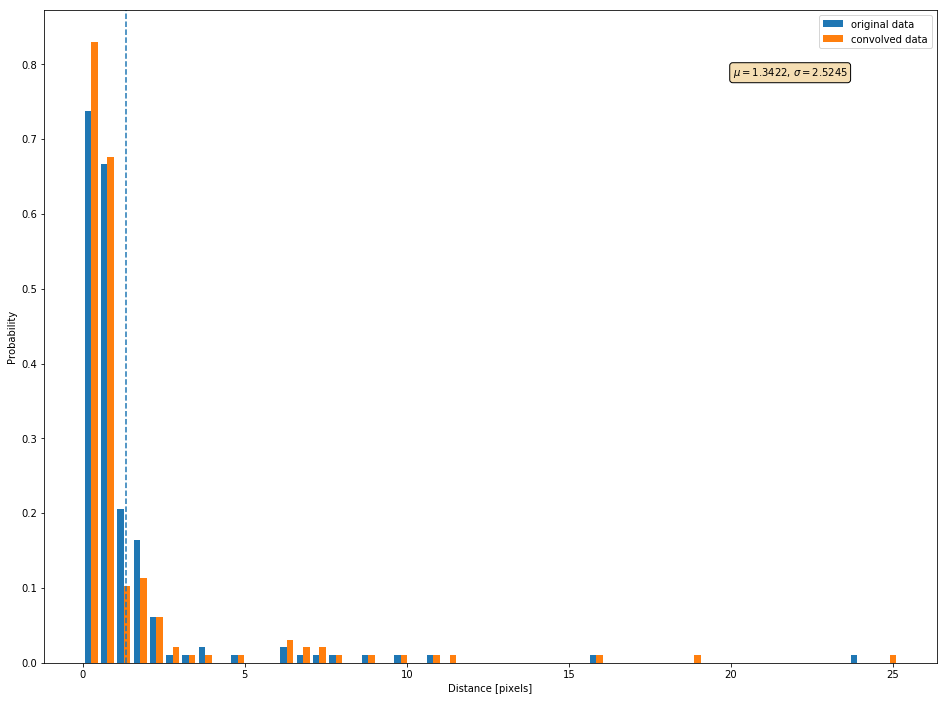

In [12]:
distances = np.zeros(len(objects))
distances_conv = np.zeros(len(objects))
for (i, o) in enumerate(objects):
    distances[i] = np.sqrt((o['x']-o['xpeak'])**2 + (o['y']-o['ypeak'])**2)
    distances_conv[i] = np.sqrt((o['x']-o['xcpeak'])**2 + (o['y']-o['ycpeak'])**2)
    
mean = np.mean(distances)
std = np.std(distances)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
hist = ax.hist([distances, distances_conv], bins=50, density=True, label=["original data", "convolved data"])
ax.set_xlabel("Distance [pixels]")
ax.set_ylabel("Probability")
ax.axvline(x=mean, linestyle='dashed')
props = dict(boxstyle='round', facecolor='wheat')
ax.text(0.9,0.9, r"$\mu={:.4f}$, $\sigma={:.4f}$".format(mean, std), transform=ax.transAxes, ha="right", bbox=props)
ax.legend(loc="upper right")

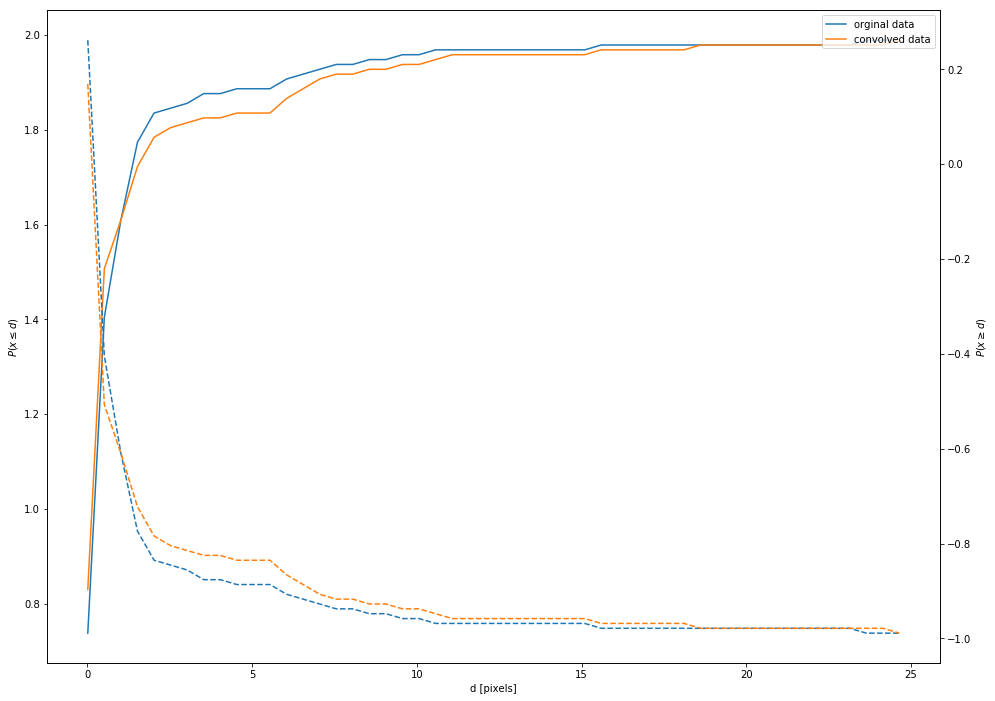

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))
ax2 = ax1.twinx()
cumulative = np.cumsum(hist[0][0])
cumulative_conv = np.cumsum(hist[0][1])
ax1.plot(hist[1][:-1], cumulative, label="orginal data")
ax1.plot(hist[1][:-1], cumulative_conv, label="convolved data")
ax2.plot(hist[1][:-1], 1.0-cumulative, label="orginal data", linestyle='dashed')
ax2.plot(hist[1][:-1], 1.0-cumulative_conv, label="convolved data", linestyle='dashed')
ax1.set_xlabel("d [pixels]")
ax1.set_ylabel(r"$P(x\leq d)$")
ax2.set_ylabel(r"$P(x\geq d)$")
ax1.legend(loc="upper right")

# Signal-to-noise ratio map

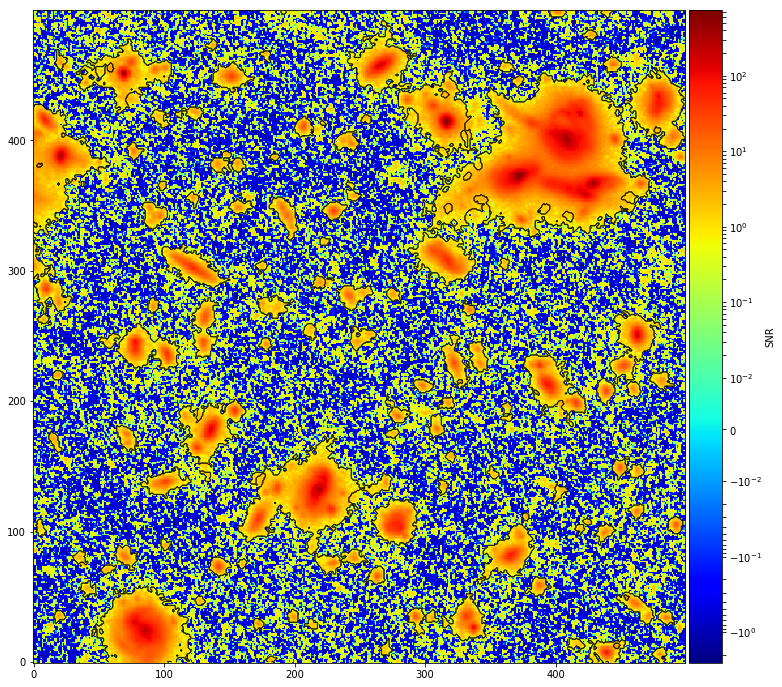

In [14]:
snr = image_1 / rms_1
contours = np.array(segmap)
contours[contours>0.0] = 1.0
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(snr, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.contour(contours, colors="black", linewidths=0.3)
fig.colorbar(im, cax=cax, orientation='vertical', label="SNR")